# Study based on Chapter 15

Grid searching is generally not an operation that we can perform with deep learning methodsThis is because deep learning methods often require large amounts of data and large modelstogether resulting in models that take hours, days, or weeks to train. In those cases where thedatasets are smaller, such as univariate time series, it may be possible to use a grid search totune the hyperparameters of a deep learning model. In this tutorial, you will discover how todevelop a framework to grid search hyperparameters for deep learning models. After completingthis tutorial, you will know:

* How to develop a generic grid searching framework for tuning model hyperparameters.
* How to grid search hyperparameters for a Multilayer Perceptron model on the airlinepassengers univariate time series forecasting problem.
* How to adapt the framework to grid search hyperparameters for convolutional and longshort-term memory neural networks.Let’s get starte

15.1 Tutorial Overview
This tutorial is divided into five parts; they are:

1. Time Series Problem
2. Grid Search Framework
3. Multilayer Perceptron Model
4. Convolutional Neural Network Model
5. Long Short-Term Memory Network Model

### 15.2 Time Series Problem

In [49]:
from math import sqrt
from numpy import mean
from pandas import read_csv
from sklearn.metrics import mean_squared_error

In [50]:
# grid search simple forecasts
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
# load
series = pd.read_csv('../data_and_models/airline-passenger.csv', header=0, index_col=0)
series.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 1949-01 to 1960-12
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2+ KB


In [53]:
series.shape

(144, 1)

In [54]:
series.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [55]:
series.tail()

,Passengers
Month,
1960-08,606
1960-09,508
1960-10,461
1960-11,390
1960-12,432


### Create a line plot of the dataset.

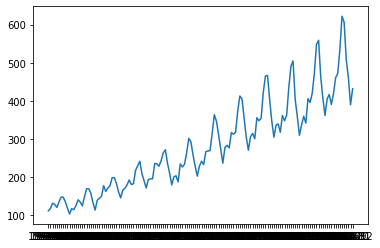

In [56]:
# plot
plt.plot(series)
plt.show()

## 15.3 Develop a Grid Search Framework
In this section, we will develop a grid search test harness that can be used to evaluate a range of
hyperparameters for different neural network models, such as MLPs, CNNs, and LSTMs. This
section is divided into the following parts:

1. Train-Test Split
2. Series as Supervised Learning
3. Walk-Forward Validation
4. Repeat Evaluation
5. Summarize Performance
6. Worked Example

In [57]:
def train_test_split(data, n_test):
    """
    Split time series in train and test sets.
    """
    return data[:-n_test], data[-n_test:]

### 15.3.2 Series as Supervised Learning
!!! CONCEITO IMPORTANTE

In [58]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    
    # put it all together
    agg = concat(cols, axis=1)
    
    # drop rows with NaN values
    agg.dropna(inplace=True)
    
    return agg.values

In [59]:
# fit a model
def model_fit(train, config):
    return None

In [60]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    return 0.0

In [61]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [62]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    
    # split dataset
    train, test = train_test_split(data, n_test)
    
    # fit model
    model = model_fit(train, cfg)
    
    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        
        # store forecast in list of predictions
        predictions.append(yhat)
        
        # add actual observation to history for the next loop
        history.append(test[i])
    
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

In [63]:
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
    # convert config to a key
    key = str(config)
    
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    
    # summarize score
    result = mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)


In [64]:
# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = [repeat_evaluate(data, n_test, cfg) for cfg in cfg_list]
    
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [65]:
# define config
cfg_list = [1, 6, 12, 24, 36]

In [66]:
# forecast with a pre-fit model
def model_predict(model, history, offset):
    history[-offset]

In [67]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

### Running the grid search

In [68]:
data = series.values

# data split
n_test = 12
# model configs
cfg_list = [1, 6, 12, 24, 36]
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:10]:
    print(cfg, error)

### 15.4 Multilayer Perceptron Model

In this section we will grid search hyperparameters for an MLPs for univariate time series
forecasting. For more details on modeling a univariate time series with an MLP, see Chapter 7.
There are many aspects of the MLP that we may wish to tune. We will define a very simple
model with one hidden layer and define five hyperparameters to tune. They are:
* n input: The number of prior inputs to use as input for the model (e.g. 12 months).
* n nodes: The number of nodes to use in the hidden layer (e.g. 50).
* n epochs: The number of training epochs (e.g. 1000).
15.4. Multilayer Perceptron Model 300
* n batch: The number of samples to include in each mini-batch (e.g. 32).
* n diff: The difference order (e.g. 0 or 12)

In [69]:
# grid search mlps for monthly airline passengers dataset
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

In [70]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [71]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    
    # put it all together
    agg = concat(cols, axis=1)
    
    # drop rows with NaN values
    agg.dropna(inplace=True)
    
    return agg.values

In [72]:
#series.values

In [73]:
series_to_supervised(series.values, 132).shape

(12, 133)

In [74]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [75]:
# difference dataset
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

In [76]:
i = 12
order = 1
data[i]

array([115])

In [77]:
data[i - order] 

array([118])

In [78]:
data[:12]

array([[112],
       [118],
       [132],
       [129],
       [121],
       [135],
       [148],
       [148],
       [136],
       [119],
       [104],
       [118]])

In [79]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    
    # transform series into supervised format
    data = series_to_supervised(train, n_in=n_input)
    
    # separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # fit model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

In [80]:
# forecast with the fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    
    # shape input for model
    x_input = array(history[-n_input:]).reshape((1, n_input))
    
    # make forecast
    yhat = model.predict(x_input, verbose=0)
    
    # correct forecast if it was differenced
    return correction + yhat[0]

In [81]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    
    # split dataset
    train, test = train_test_split(data, n_test)
    
    # fit model
    model = model_fit(train, cfg)
    
    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        
        # store forecast in list of predictions
        predictions.append(yhat)
        
        # add actual observation to history for the next loop
        history.append(test[i])
        
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    
    return error

In [82]:
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
    # convert config to a key
    key = str(config)
    
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    
    # summarize score
    result = mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    
    return scores

In [83]:
# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [12]
    n_nodes = [50, 100]
    n_epochs = [100]
    n_batch = [1, 150]
    n_diff = [0, 12]

    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [84]:
# define dataset
series = pd.read_csv('../data_and_models/airline-passenger.csv', header=0, index_col=0)
data = series.values

In [ ]:
# data split
n_test = 12

# model configs
cfg_list = model_configs()

# grid search
scores = grid_search(data, cfg_list, n_test)

print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

## 15.5 CNNs


In [88]:
# grid search cnn for monthly airline passengers dataset
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [89]:
# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch, n_diff = config
    
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    
    # transform series into supervised format
    data = series_to_supervised(train, n_in=n_input)
    # separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    
    # reshape input data into [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    
    # define model
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu',
    input_shape=(n_input, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [90]:
# forecast with the fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, _, n_diff = config
    
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
   
    # forecast
    yhat = model.predict(x_input, verbose=0)
    
    return correction + yhat[0]

In [91]:
def model_configs():
    # define scope of configs
    n_input = [12]
    n_filters = [64]
    n_kernels = [3, 5]
    n_epochs = [100]
    n_batch = [1, 150]
    n_diff = [0, 12]
    # create configs
    configs = list()
    for a in n_input:
        for b in n_filters:
            for c in n_kernels:
                for d in n_epochs:
                    for e in n_batch:
                        for f in n_diff:
                            cfg = [a,b,c,d,e,f]
                            configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [93]:
%%time
# data split
n_test = 12

# model configs
cfg_list = model_configs()

# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')

# list top 10 configs
for cfg, error in scores[:3]:
    print(cfg, error)

Total configs: 8
 > 19.631
 > 21.550
 > 25.016
 > 17.021
 > 26.741
 > 17.420
 > 18.950
 > 27.614
 > 38.216
 > 31.985
> Model[[12, 64, 3, 100, 1, 0]] 24.414
 > 20.240
 > 19.492
 > 20.920
 > 20.819
 > 19.906
 > 20.733
 > 19.845
 > 20.592
 > 19.831
 > 19.292
> Model[[12, 64, 3, 100, 1, 12]] 20.167
 > 81.722
 > 86.048
 > 70.959
 > 82.400
 > 70.845
 > 73.856
 > 83.625
 > 86.015
 > 81.897
 > 81.070
> Model[[12, 64, 3, 100, 150, 0]] 79.843
 > 18.597
 > 19.423
 > 19.185
 > 19.324
 > 19.773
 > 19.740
 > 18.876
 > 19.312
 > 18.818
 > 18.936
> Model[[12, 64, 3, 100, 150, 12]] 19.198
 > 18.981
 > 23.938
 > 19.812
 > 23.352
 > 18.407
 > 18.233
 > 21.024
 > 22.139
 > 17.963
 > 19.619
> Model[[12, 64, 5, 100, 1, 0]] 20.347
 > 20.346
 > 19.468
 > 20.027
 > 19.441
 > 19.155
 > 18.934
 > 18.985
 > 17.320
 > 18.757
 > 18.034
> Model[[12, 64, 5, 100, 1, 12]] 19.047
 > 86.240
 > 84.664
 > 91.095
 > 81.624
 > 76.943
 > 72.333
 > 75.970
 > 73.582
 > 85.603
 > 85.898
> Model[[12, 64, 5, 100, 150, 0]] 81.395
 

In [94]:
[12, 100, 100, 1, 12] 19.06148846919292
[12, 100, 100, 150, 12] 19.105602487171115
[12, 50, 100, 1, 12] 19.686681506146975

SyntaxError: invalid syntax (<ipython-input-94-0152513e7755>, line 1)

## 15.6 Long Short-Term Memory Network Model
We can now adopt the framework for grid searching the hyperparameters of an LSTM model.
For more details on modeling a univariate time series with an LSTM network, see Chapter 9.
The hyperparameters for the LSTM model will be the same five as the MLP; they are:
* n input: The number of prior inputs to use as input for the model (e.g. 12 months).
* n nodes: The number of nodes to use in the hidden layer (e.g. 50).
* n epochs: The number of training epochs (e.g. 1000).
* n batch: The number of samples to include in each mini-batch (e.g. 32).
* n diff: The difference order (e.g. 0 or 12).

```python
# define model
model = Sequential()
model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_nodes, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit model
model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
```

In [1]:
# grid search lstm for monthly airline passengers dataset
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [46]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [2]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [30]:
# difference dataset
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

In [3]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    
    # put it all together
    agg = concat(cols, axis=1)
    
    # drop rows with NaN values
    agg.dropna(inplace=True)
    
    return agg.values

In [32]:
# fit a model
def model_fit_lstm(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    
    # transform series into supervised format
    data = series_to_supervised(train, n_in=n_input)
    # separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    
    # reshape input data into [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [33]:
# forecast with the fit model
def model_predict_lstm(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
   
    # forecast
    yhat = model.predict(x_input, verbose=0)
    
    return correction + yhat[0]

In [34]:
# walk-forward validation for univariate data
def walk_forward_validation_lstm(data, n_test, cfg):
    predictions = list()
    
    # split dataset
    train, test = train_test_split(data, n_test)
    
    # fit model
    model = model_fit_lstm(train, cfg)
    
    # seed history with training dataset
    history = [x for x in train]
    
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict_lstm(model, history, cfg)
        
        # store forecast in list of predictions
        predictions.append(yhat)
        
        # add actual observation to history for the next loop
        history.append(test[i])
        
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    
    return error

In [35]:
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
    # convert config to a key
    key = str(config)
    
    # fit and evaluate the model n times
    scores = [walk_forward_validation_lstm(data, n_test, config) for _ in range(n_repeats)]
    
    # summarize score
    result = mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

In [36]:
# create a list of configs to try
def model_configs_lstm():
    # define scope of configs
    n_input = [12]
    n_nodes = [100]
    n_epochs = [100]
    n_batch = [1, 150]
    n_diff = [12]

    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [37]:
# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    
    return scores


In [48]:
%%time
# define dataset
series = pd.read_csv('../data_and_models/airline-passenger.csv', header=0, index_col=0)
data = series.values

# data split
n_test = 12

# model configs
cfg_list = model_configs_lstm()

# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')

# list top 10 configs
for cfg, error in scores[:3]:
    print(cfg, error)

Total configs: 2
 > 22.386
 > 21.881
 > 31.541
 > 33.765
 > 24.281
 > 19.710
 > 22.497
 > 18.430
 > 20.553
 > 27.632
> Model[[12, 100, 100, 1, 12]] 24.268
 > 23.138
 > 25.026
 > 18.997
 > 20.082
 > 20.239
 > 25.648
 > 21.359
 > 23.385
 > 18.732
 > 25.904
> Model[[12, 100, 100, 150, 12]] 22.251
done
[12, 100, 100, 150, 12] 22.251091556997228
[12, 100, 100, 1, 12] 24.267532783547612
CPU times: user 17min 15s, sys: 1min 35s, total: 18min 51s
Wall time: 8min 53s
